## **1. 라이브러리 설치**

In [ ]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 88.9 MB/s eta 0:00:00


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
from google.colab import files
import os
import zipfile
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import yaml
import shutil
from tqdm import tqdm
from glob import glob
import random
import numpy as np
import torch
from ultralytics import YOLO
from IPython.display import Image, display
import glob
import koreanize_matplotlib
from google.colab import files
from glob import glob
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **2. 시드 고정**
- 재현 가능한 결과를 위해 random, numpy, torch의 시드를 고정한다.
- 이를 통해 매 실행마다 동일한 데이터 셔플링, weight 초기화 등을 보장받을 수 있다.

In [ ]:
random.seed(71)
np.random.seed(71)
torch.manual_seed(71)
torch.cuda.manual_seed(71)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **3. 데이터 경로 설정**
- Google Drive에서 Colab 환경으로 압축 해제하고, 모델 훈련에 사용할 데이터 경로를 지정한다.

In [ ]:
# 데이터 경로
data_path = '/content/drive/MyDrive/codeit_level1_project/additional_data'
test_dir = '/content/drive/MyDrive/codeit_level1_project/data/test_images'

## **4. YOLO11x 모델 훈련 및 검증**

### 4.1 모델 구성 및 학습 실행
- 앞서 실험에서는 YOLOv8n(속도 우선)과 YOLOv8x(성능 우선)을 각각 적용하여 모델 성능을 비교하였다.

- 이번에는 보다 최신 버전인 YOLOv11 계열 중 가장 높은 성능을 보이는 YOLOv11x 모델을 선정하였다.

- Ultralytics에서 공개한 성능 비교표에 따르면, YOLOv11x는 다음과 같은 성능을 보인다.

| 모델          | 입력 크기 | mAPval 50-95 | 속도 (CPU ONNX) | 속도 (T4 TensorRT10) | 매개변수 수 | FLOPs   |
| ----------- | ----- | ------------ | ------------- | ------------------ | ------ | ------- |
| YOLO11n     | 640   | 39.5         | 56.1 ± 0.8    | 1.5 ± 0.0          | 2.6 M  | 6.5 B   |
| YOLO11s     | 640   | 47.0         | 90.0 ± 1.2    | 2.5 ± 0.0          | 9.4 M  | 21.5 B  |
| YOLO11m     | 640   | 51.5         | 183.2 ± 2.0   | 4.7 ± 0.1          | 20.1 M | 68.0 B  |
| YOLO11l     | 640   | 53.4         | 238.6 ± 1.4   | 6.3 ± 0.2          | 25.3 M | 86.9 B  |
| **YOLO11x** | 640   | **54.7**     | 462.8 ± 6.7   | 11.3 ± 0.2         | 56.9 M | 194.9 B |


In [ ]:
model = YOLO("yolo11x.pt")

100%|██████████| 109M/109M [00:00<00:00, 508MB/s]


- 성능 향상을 위해 에폭 수는 100으로 설정하였으며,
제한된 GPU 환경을 고려하여 배치 사이즈는 16으로 조정하였다.
- 또한, 실험 결과의 재현성 확보를 위해 시드는 71로 고정하였다.

In [ ]:
results = model.train(
    data='/content/drive/MyDrive/codeit_level1_project/data/data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,  # GPU 메모리에 따라 조정
    device=0,
    cache=True,
    project="/content/drive/MyDrive/codeit_level1_project/yolo11_add/",
    name="train_result",
    seed=71
)

Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/codeit_level1_project/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_result, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.

100%|██████████| 22.2M/22.2M [00:00<00:00, 263MB/s]

Overriding model.yaml nc=80 with nc=73

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     


  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  8                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  9                  -1  1   1476864  ultralytics.nn.modules.block.SPPF            [768, 768, 5]                 
 10                  -1  2   3264768  ultralytics.nn.modules.block.C2PSA           [768, 768, 2]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   5612544  ultralytics.nn.modules.block.C3k2            [1536

100%|██████████| 5.35M/5.35M [00:00<00:00, 426MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 2.1±0.2 MB/s, size: 1728.9 KB)


train: Scanning /content/drive/MyDrive/codeit_level1_project/additional_data/labels/train.cache... 1484 images, 0 backgrounds, 3 corrupt: 100%|██████████| 1484/1484 [00:00<?, ?it/s]

train: /content/drive/MyDrive/codeit_level1_project/additional_data/images/train/K-003351-016262-018357_0_2_0_2_75_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     6.8878]
train: /content/drive/MyDrive/codeit_level1_project/additional_data/images/train/K-003544-012247-016548-029451_0_2_0_2_90_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.1211]
train: /content/drive/MyDrive/codeit_level1_project/additional_data/images/train/K-006563-012247-016551-024850_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     5.8352]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (1.3GB RAM): 100%|██████████| 1481/1481 [01:35<00:00, 15.53it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 2.2±0.5 MB/s, size: 1702.9 KB)


val: Scanning /content/drive/MyDrive/codeit_level1_project/additional_data/labels/val.cache... 579 images, 0 backgrounds, 2 corrupt: 100%|██████████| 579/579 [00:00<?, ?it/s]

val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016548-024850-029451_0_2_0_2_75_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1419      2.0318]
val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016551-021771-031705_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.3945      4.6352]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.5GB RAM): 100%|██████████| 577/577 [00:20<00:00, 27.53it/s]


Plotting labels to /content/drive/MyDrive/codeit_level1_project/yolo11_add/train_result/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00013, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/codeit_level1_project/yolo11_add/train_result
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.9G      1.487      4.992      1.591        105        640:   2%|▏         | 2/93 [00:02<01:42,  1.12s/it]

      1/100      14.9G      1.442      5.024      1.522        113        640:   4%|▍         | 4/93 [00:03<01:17,  1.14it/s]
100%|██████████| 755k/755k [00:00<00:00, 124MB/s]
      1/100      14.9G     0.6043      2.256      1.016         74        640: 100%|██████████| 93/93 [01:10<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]

                   all        577       2308      0.893       0.89      0.962      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      15.4G     0.3833     0.6549      0.885         76        640: 100%|██████████| 93/93 [01:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.968       0.98      0.974      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      15.5G     0.3894     0.5182       0.89         71        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.966      0.965      0.976      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      15.6G     0.3699     0.4539     0.8816         44        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308       0.97      0.977      0.976      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      15.4G     0.3588     0.4295     0.8835         80        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.974      0.973      0.978      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      15.6G     0.3484     0.3917     0.8812         77        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.982      0.984      0.978      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      15.6G      0.337      0.376     0.8746         44        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.974      0.979      0.978       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      15.5G     0.3302     0.3386     0.8731         69        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.978      0.983      0.976      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      15.4G     0.3208     0.3249     0.8688         59        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308       0.98       0.98      0.979      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      15.6G       0.32     0.3288     0.8685         67        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.981      0.981      0.976      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      15.6G     0.3108     0.2966     0.8619         70        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308       0.98      0.984      0.977      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      15.6G     0.2986      0.287     0.8574         59        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.982      0.983       0.98      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      15.4G     0.3014     0.2937     0.8592         69        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.983      0.984      0.978      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      15.5G     0.3031     0.2824     0.8625         58        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984       0.98      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      15.6G     0.2848     0.2735     0.8534         61        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.979      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      15.5G     0.2875     0.2768      0.855         74        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.981      0.984      0.978       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      15.4G     0.2879     0.2606     0.8585         70        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308       0.98      0.981      0.978      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      15.5G      0.287     0.2637     0.8559         73        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984       0.98      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      15.6G     0.2867     0.2678      0.857         77        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.982      0.984      0.978      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      15.5G     0.2825      0.258     0.8577         41        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.979      0.976      0.978       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      15.4G     0.2821     0.2547     0.8562         58        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        577       2308       0.98      0.984       0.98      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      15.5G     0.2804     0.2621     0.8575         73        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.979      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      15.6G     0.2696     0.2464     0.8511         58        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.982      0.981      0.978      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      15.5G     0.2676     0.2393     0.8503         69        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.984      0.984      0.978      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      15.4G     0.2621     0.2326     0.8482         43        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.983      0.984      0.979      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      15.5G     0.2656     0.2322     0.8475         59        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984       0.98      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      15.6G     0.2657     0.2357     0.8478         57        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984       0.98      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      15.5G      0.263     0.2314     0.8489         61        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.982      0.984      0.977      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      15.4G     0.2648     0.2325     0.8474         99        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.978      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      15.6G     0.2472     0.2152     0.8418         53        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.982      0.984      0.978       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      15.6G     0.2561       0.23     0.8461         67        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.982      0.984      0.976      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      15.5G     0.2522     0.2226     0.8434         85        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.983      0.984      0.978      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      15.4G     0.2555      0.223     0.8495         67        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        577       2308      0.983      0.984      0.979      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      15.6G     0.2542     0.2244     0.8476         51        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.983      0.978      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      15.6G     0.2563     0.2274     0.8456         66        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        577       2308      0.983      0.984      0.978      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      15.6G     0.2512     0.2175     0.8457         68        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.977      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      15.4G     0.2413     0.2068     0.8427         52        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.984      0.984      0.979      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      15.6G     0.2413     0.2055     0.8425         70        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      15.6G     0.2454      0.215     0.8444         67        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      15.5G     0.2412     0.2086     0.8406         63        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984       0.98       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      15.3G     0.2453     0.2059     0.8413         71        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984       0.98      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      15.6G     0.2389     0.1998       0.84         59        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.978      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      15.5G     0.2441     0.2044     0.8427         63        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.978      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      15.5G      0.232     0.1991     0.8379         51        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      15.3G     0.2326     0.2034     0.8338         55        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      15.6G     0.2345     0.2033     0.8393         47        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.984      0.984      0.979      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      15.5G     0.2353     0.2003     0.8421         65        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        577       2308      0.984      0.984       0.98      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      15.6G     0.2347     0.2008     0.8378         51        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.984      0.984      0.979      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      15.3G     0.2295     0.1985     0.8375         61        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.981      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      15.6G     0.2325     0.1966     0.8414         64        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.978      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      15.5G     0.2301     0.1975     0.8338         79        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.983      0.984      0.981       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      15.6G     0.2269     0.1906     0.8326         68        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.984      0.984       0.98       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      15.4G     0.2218     0.1853     0.8318         67        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      15.6G     0.2275     0.1837     0.8365         55        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.982      0.983      0.979      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      15.5G     0.2195     0.1881     0.8319         74        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      15.6G     0.2194     0.1814     0.8317         62        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.978      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      15.4G     0.2204     0.1883     0.8348         66        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984       0.98      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      15.6G     0.2255     0.1872     0.8375         53        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      15.5G     0.2211     0.1825     0.8337         76        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984       0.98       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      15.5G     0.2201     0.1819     0.8298         51        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        577       2308      0.984      0.984      0.981       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      15.4G     0.2181     0.1839      0.838         84        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.984      0.984       0.98       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      15.5G     0.2142     0.1849     0.8332         61        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        577       2308      0.984      0.984      0.978      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      15.6G     0.2134     0.1806     0.8299         60        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984       0.98       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      15.6G      0.209      0.171     0.8261         41        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.23it/s]

                   all        577       2308      0.983      0.984       0.98      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      15.4G      0.205      0.171     0.8287         68        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      15.6G     0.2094     0.1726     0.8277         73        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      15.5G      0.209     0.1742     0.8335         60        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.979      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      15.5G      0.206      0.168     0.8258         52        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      15.4G     0.2033     0.1683     0.8299         62        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.978      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      15.6G     0.2036     0.1676     0.8263         68        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.978       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      15.6G     0.2023     0.1663     0.8305         62        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.984      0.984      0.979      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      15.5G     0.2022     0.1677     0.8328         80        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984       0.98       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      15.4G     0.1965     0.1623     0.8263         77        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.984      0.984      0.978      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      15.5G     0.2004     0.1602     0.8294         58        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      15.6G     0.1962     0.1555     0.8239         66        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      15.6G     0.1942     0.1541     0.8258         95        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.978      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      15.4G     0.1892     0.1508     0.8224         62        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.978      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      15.6G     0.1945     0.1557     0.8275         69        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.978      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      15.5G     0.1951     0.1575     0.8284         55        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      15.6G     0.1909     0.1505     0.8239         60        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984       0.98      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      15.4G     0.1897     0.1488     0.8211         64        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        577       2308      0.984      0.984       0.98      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      15.5G      0.183     0.1429     0.8237         62        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

                   all        577       2308      0.984      0.984      0.979      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      15.6G     0.1869     0.1475     0.8213         80        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.979      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      15.5G     0.1878     0.1453     0.8232         57        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.983      0.979       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      15.3G     0.1844      0.144     0.8219         85        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.984      0.984      0.979       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      15.6G     0.1831      0.144     0.8189         88        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.978      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      15.6G     0.1814     0.1442     0.8231         60        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.979       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      15.6G     0.1783      0.142     0.8212         51        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.979      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      15.4G     0.1784     0.1402      0.819         61        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.983      0.984      0.978       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      15.6G     0.1761     0.1355     0.8211         60        640: 100%|██████████| 93/93 [01:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.971


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      15.5G      0.149     0.1126     0.7931         35        640: 100%|██████████| 93/93 [01:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.982      0.984      0.978       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      15.5G      0.147     0.1105     0.7912         36        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.979      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      15.3G     0.1457     0.1083     0.7918         33        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.983       0.98      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      15.5G     0.1437     0.1075     0.7909         36        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.979      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      15.5G     0.1422     0.1059     0.7925         33        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.983      0.984      0.979      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      15.5G     0.1415     0.1047     0.7904         36        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.984      0.984      0.979      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      15.3G     0.1424     0.1066     0.7942         35        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]

                   all        577       2308      0.984      0.984      0.979      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      15.5G     0.1372     0.1016     0.7888         36        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.984      0.979      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      15.5G     0.1377     0.1012     0.7915         33        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.983      0.979      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      15.5G     0.1366     0.1014     0.7916         36        640: 100%|██████████| 93/93 [01:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.25it/s]

                   all        577       2308      0.983      0.983      0.979      0.972



100 epochs completed in 2.146 hours.
Optimizer stripped from /content/drive/MyDrive/codeit_level1_project/yolo11_add/train_result/weights/last.pt, 114.5MB
Optimizer stripped from /content/drive/MyDrive/codeit_level1_project/yolo11_add/train_result/weights/best.pt, 114.5MB

Validating /content/drive/MyDrive/codeit_level1_project/yolo11_add/train_result/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11x summary (fused): 190 layers, 56,911,339 parameters, 0 gradients, 194.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]


                   all        577       2308      0.983      0.983       0.98      0.972
            쎄로켈정 100mg        162        162      0.993      0.994      0.994      0.986
           아빌리파이정 10mg        206        206      0.985      0.985      0.985      0.977
          자이프렉사정 2.5mg        209        209       0.99       0.99      0.994       0.99
           가바토파정 100mg        269        269      0.988      0.989      0.983      0.981
         동아가바펜틴정 800mg        308        308      0.974      0.971      0.968      0.965
        란스톤엘에프디티정 30mg         89         89      0.987      0.989       0.99      0.968
             스토가정 10mg         86         86      0.987      0.988      0.984      0.981
          펠루비정(펠루비프로펜)         91         91      0.944      0.945      0.921      0.921
            라비에트정 20mg        101        101       0.98       0.98      0.971      0.968
              놀텍정 10mg        102        102       0.99      0.973      0.994      0.979
             울트라셋이알서방

### 4.2 검증 데이터 성능 평가
- YOLOv11x 모델은 검증 데이터셋 577장의 이미지에 대해 성능을 평가하였다.
- 일부 라벨이 비정상적으로 범위를 초과한 두 이미지는 자동으로 무시되었다.
- 최종 성능은 아래와 같으며, 전체 클래스에 대한 정밀도(Precision), 재현율(Recall), 그리고 mAP 지표에서 우수한 결과를 보였다.

| 지표          | 값         |
| ------------- | --------- -|
| Precision     | **0.983** |
| Recall        | **0.983** |
| mAP\@0.5      | **0.980** |
| mAP\@0.5:0.95 | **0.972** |




In [ ]:
model = YOLO("/content/drive/MyDrive/codeit_level1_project/yolo11_add/train_result/weights/best.pt")
metrics = model.val()
print(metrics.box)

Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11x summary (fused): 190 layers, 56,911,339 parameters, 0 gradients, 194.9 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 521.1±47.7 MB/s, size: 1708.7 KB)


val: Scanning /content/drive/MyDrive/codeit_level1_project/additional_data/labels/val.cache... 579 images, 0 backgrounds, 2 corrupt: 100%|██████████| 579/579 [00:00<?, ?it/s]

val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016548-024850-029451_0_2_0_2_75_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1419      2.0318]
val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016551-021771-031705_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.3945      4.6352]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:15<00:00,  2.45it/s]


                   all        577       2308      0.983      0.983       0.98      0.972
            쎄로켈정 100mg        162        162      0.993      0.994      0.994      0.986
           아빌리파이정 10mg        206        206      0.985      0.985      0.985      0.976
          자이프렉사정 2.5mg        209        209       0.99       0.99      0.994       0.99
           가바토파정 100mg        269        269      0.988      0.989      0.983      0.981
         동아가바펜틴정 800mg        308        308      0.974      0.971      0.968      0.964
        란스톤엘에프디티정 30mg         89         89      0.987      0.989       0.99      0.967
             스토가정 10mg         86         86      0.987      0.988      0.985      0.983
          펠루비정(펠루비프로펜)         91         91      0.944      0.945      0.921      0.921
            라비에트정 20mg        101        101       0.98       0.98      0.971      0.968
              놀텍정 10mg        102        102       0.99      0.973      0.994      0.978
             울트라셋이알서방

## **5. 모델 평가**
- 학습된 YOLOv11x 모델의 best.pt 가중치를 활용하여 테스트 이미지에 대한 객체 탐지 예측을 수행하였다.
- 테스트 결과는 시각적으로 확인했으며, 대부분의 알약에 대해 정확한 클래스 및 바운딩 박스가 예측되었음을 확인하였다.
- 예측된 객체에는 알약 이름 (클래스명), 정확도(confidence), 바운딩 박스가 함께 표시되어 있다.

In [ ]:
model = YOLO("/content/drive/MyDrive/codeit_level1_project/yolo11_add/train_result/weights/best.pt")
results = model.predict(
    source=test_dir,
    imgsz=640,
    conf=0.25,
    save=True,
    project="/content/drive/MyDrive/codeit_level1_project/yolo11_add/",
    name="test_result",
    exist_ok=True
)


image 1/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1.png: 640x512 1 보령부스파정 5mg, 1 동아가바펜틴정 800mg, 1 놀텍정 10mg, 1 울트라셋이알서방정, 93.8ms
image 2/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/10.png: 640x512 1 보령부스파정 5mg, 1 가바토파정 100mg, 1 라비에트정 20mg, 1 레일라정, 20.4ms
image 3/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/100.png: 640x512 1 보령부스파정 5mg, 1 가바토파정 100mg, 1 란스톤엘에프디티정 30mg, 1 신바로정, 20.6ms
image 4/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1003.png: 640x512 1 기넥신에프정(은행엽엑스)(수출용), 1 리피토정 20mg, 1 트윈스타정 40/5mg, 1 제미메트서방정 50/1000mg, 20.7ms
image 5/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1004.png: 640x512 1 기넥신에프정(은행엽엑스)(수출용), 1 리피토정 20mg, 1 트윈스타정 40/5mg, 1 제미메트서방정 50/1000mg, 20.8ms
image 6/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1005.png: 640x512 1 기넥신에프정(은행엽엑스)(수출용), 1 리피토정 20mg, 1 트윈스타정 40/5mg, 1 제미메트서방정 50/1000mg, 20.3ms
image 7/843 /content/drive/MyDriv

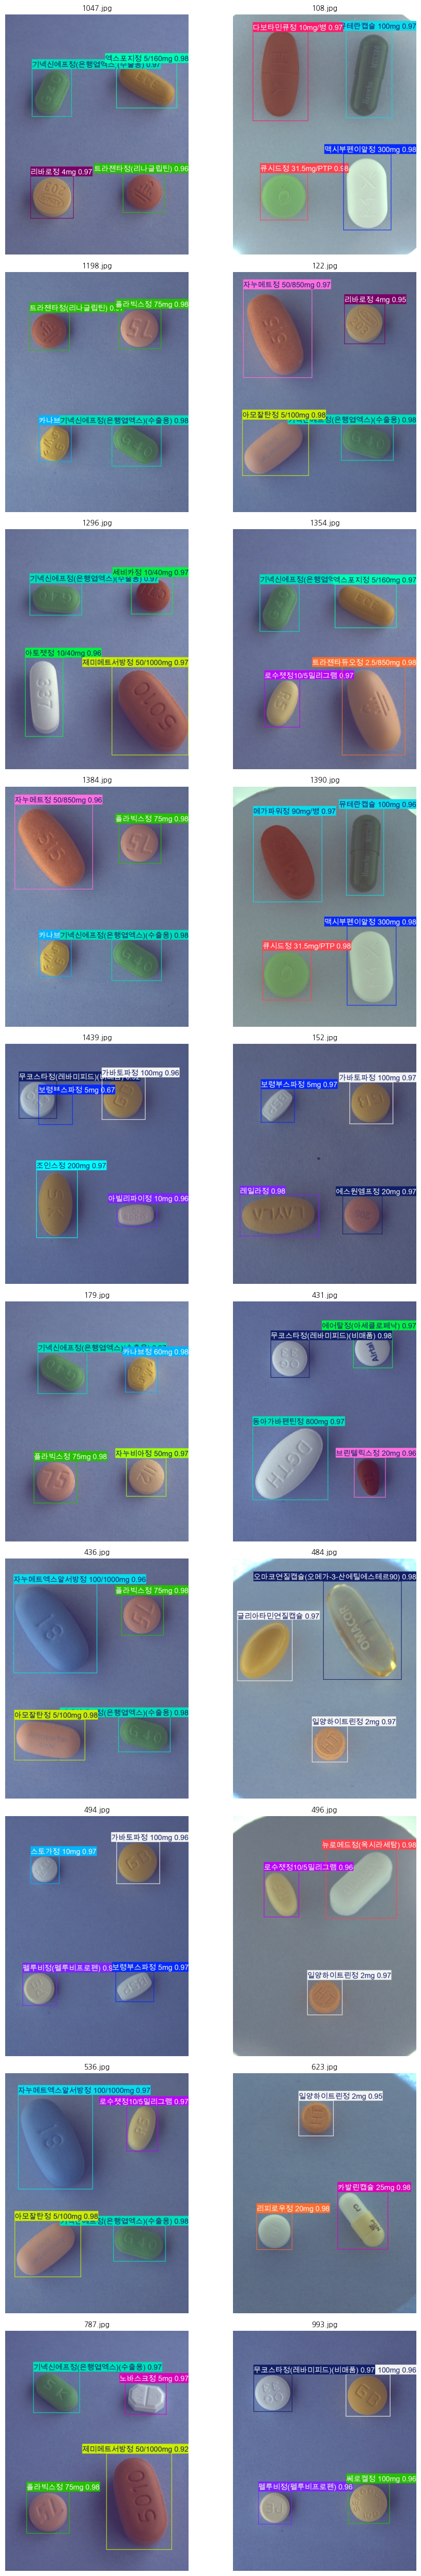

In [ ]:
def visualize_predictions(predict_dir, num_samples=20, cols=4):
    if not os.path.exists(predict_dir):
        raise FileNotFoundError(f"예측 디렉토리 '{predict_dir}'가 존재하지 않습니다.")

    # 이미지 목록 필터링
    image_files = [f for f in os.listdir(predict_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if len(image_files) == 0:
        raise ValueError("해당 디렉토리에 시각화할 이미지 파일이 없습니다.")

    # 무작위 샘플 선택 (정렬 추가)
    sample_images = sorted(random.sample(image_files, min(num_samples, len(image_files))))

    rows = (len(sample_images) + cols - 1) // cols
    plt.figure(figsize=(cols * 5, rows * 5), dpi=100)

    for i, filename in enumerate(sample_images):
        img_path = os.path.join(predict_dir, filename)
        try:
            img = Image.open(img_path).convert("RGB")
            img.thumbnail((800, 800))
        except Exception as e:
            print(f"이미지 로딩 오류: {filename} → {e}")
            continue

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(filename, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions("/content/drive/MyDrive/codeit_level1_project/yolo11_add/test_result", num_samples=20, cols=2)

## **6. 제출 csv 파일 생성**

- 모델의 예측 결과를 기반으로 Kaggle 제출 포맷에 맞는 csv 파일을 생성한다.
- test_images 폴더의 이미지 파일명은 중간중간 누락된 번호가 많기 때문에, 단순한 순번(1, 2, 3...)이 아닌, 파일명에서 추출한 실제 숫자 ID를 그대로 사용해야 한다.
- 클래스 번호는 제출 시 반드시 주어진 category_id와 정확히 매핑해야 평가가 올바르게 이루어진다.


In [ ]:
# 클래스 매핑 로드
with open("/content/drive/MyDrive/codeit_level1_project/data/classid_to_categoryid.json", "r") as f:
    class_to_category = json.load(f)
    class_to_category = {int(k): v for k, v in class_to_category.items()}

# 결과 파싱 및 저장
rows = []
annotation_id = 1

for result in results:
    # image_id: 원본 이미지 경로에서 파일명 숫자 추출
    filename = result.path.split("/")[-1]
    image_id = int(filename.split(".")[0])

    boxes = result.boxes
    if boxes is None or boxes.xywh is None:
        continue

    for i in range(len(boxes.xywh)):
        x, y, w, h = boxes.xywh[i].tolist()
        score = float(boxes.conf[i])
        cls = int(boxes.cls[i])
        category_id = class_to_category.get(cls, -1)

        if category_id == -1:
            continue  # 매핑 실패한 클래스는 제외

        # COCO 포맷: x_min, y_min, width, height
        xmin = round(x - w / 2)
        ymin = round(y - h / 2)
        bbox_w = round(w)
        bbox_h = round(h)

        rows.append([
            annotation_id,
            image_id,
            category_id,
            xmin,
            ymin,
            bbox_w,
            bbox_h,
            round(score, 2)
        ])
        annotation_id += 1

# CSV 저장
df = pd.DataFrame(rows, columns=[
    "annotation_id", "image_id", "category_id",
    "bbox_x", "bbox_y", "bbox_w", "bbox_h", "score"
])
csv_path = "/content/drive/MyDrive/codeit_level1_project/yolo11_add/submission_yolo11_add.csv"
df.to_csv(csv_path, index=False)
print(f"제출 파일 저장됨: {csv_path} (총 {len(df)}개 bounding box 포함)")

제출 파일 저장됨: /content/drive/MyDrive/codeit_level1_project/yolo11_add/submission_yolo11_add.csv (총 3260개 bounding box 포함)
